# Circumbinary planet search
This notebook starts with a "cleaned" light curve (one where the binary eclipses have been removed), and searches for planet transits that match expectations from an n-body simulation. The n-body simulation uses the binary orbital parameters (which may be simplified, e.g. by assuming i=90deg), and proposed planet parameters (semi-major axis and initial true anomaly), to derive a large set of transit times and durations for a given planet. The light curve (or some metric based on it) is then "stacked" at all transit times across the planet parameter space to search for recurring transits. Where semi-major axis and true anomaly are the planet parameters being explored, the resulting output is two-dimensional.

In [1]:
# import copy
import numpy as np
import matplotlib.pyplot as plt
# import astropy.units as u
import funcs
import known_system_params
import pickle

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# load the lightcurve, we'll use Kepler 16
lc = np.genfromtxt('lightcurves/K16_clean_noecl.txt')
time = lc[:,0]+2454833.
flux = lc[:,1]
err = lc[:,2]

In [3]:
# the system parameters
cb = known_system_params.k16

p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
f_p0 = cb.fp
print('binary period:{}days'.format(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25))
print('planet period:{} days'.format(p_p0))

binary period:41.079003449207896days
planet period:228.79461019691053 days


### Light curve statistic
Here we compute a light curve statistic. While we might simply stack the light curve and then look for transits, this relies on the n-body being perfect because the planet transits need to line up very well. This will not be the case in general as the planet may have a slightly different orbit than assumed in the simulation (e.g. be eccentric), and the binary parameters may also be incorrect. Therefore, we use a statistic derived from the light curve, which can allow for these problems by (for example) taking the lowest statistic within some window around a given time, rather than the actual local value.

Below this statistic is calculated for a range of window sizes, the reason being the the transit durations vary for circumbinary planets. For a given transit from the n-body simulation, the statistic with the closest match of window to the predicted transit duration will be used.

In [4]:
# lightcurve statistic - transfer lightcurve to a varying duration statistic. 
windows = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
minpoints = 3
blurfactor = 1.5 # using a blurfactor of 1.5 means a 3 duration window is scanned.
stat = {}
blur_stat = {}
blur_stat_t = {}
for win in windows:
    stat[win], blur_stat[win], blur_stat_t[win], _ = funcs.running_mean_gaps(time,flux-1,win,minpoints,blurfactor)

<IPython.core.display.Javascript object>


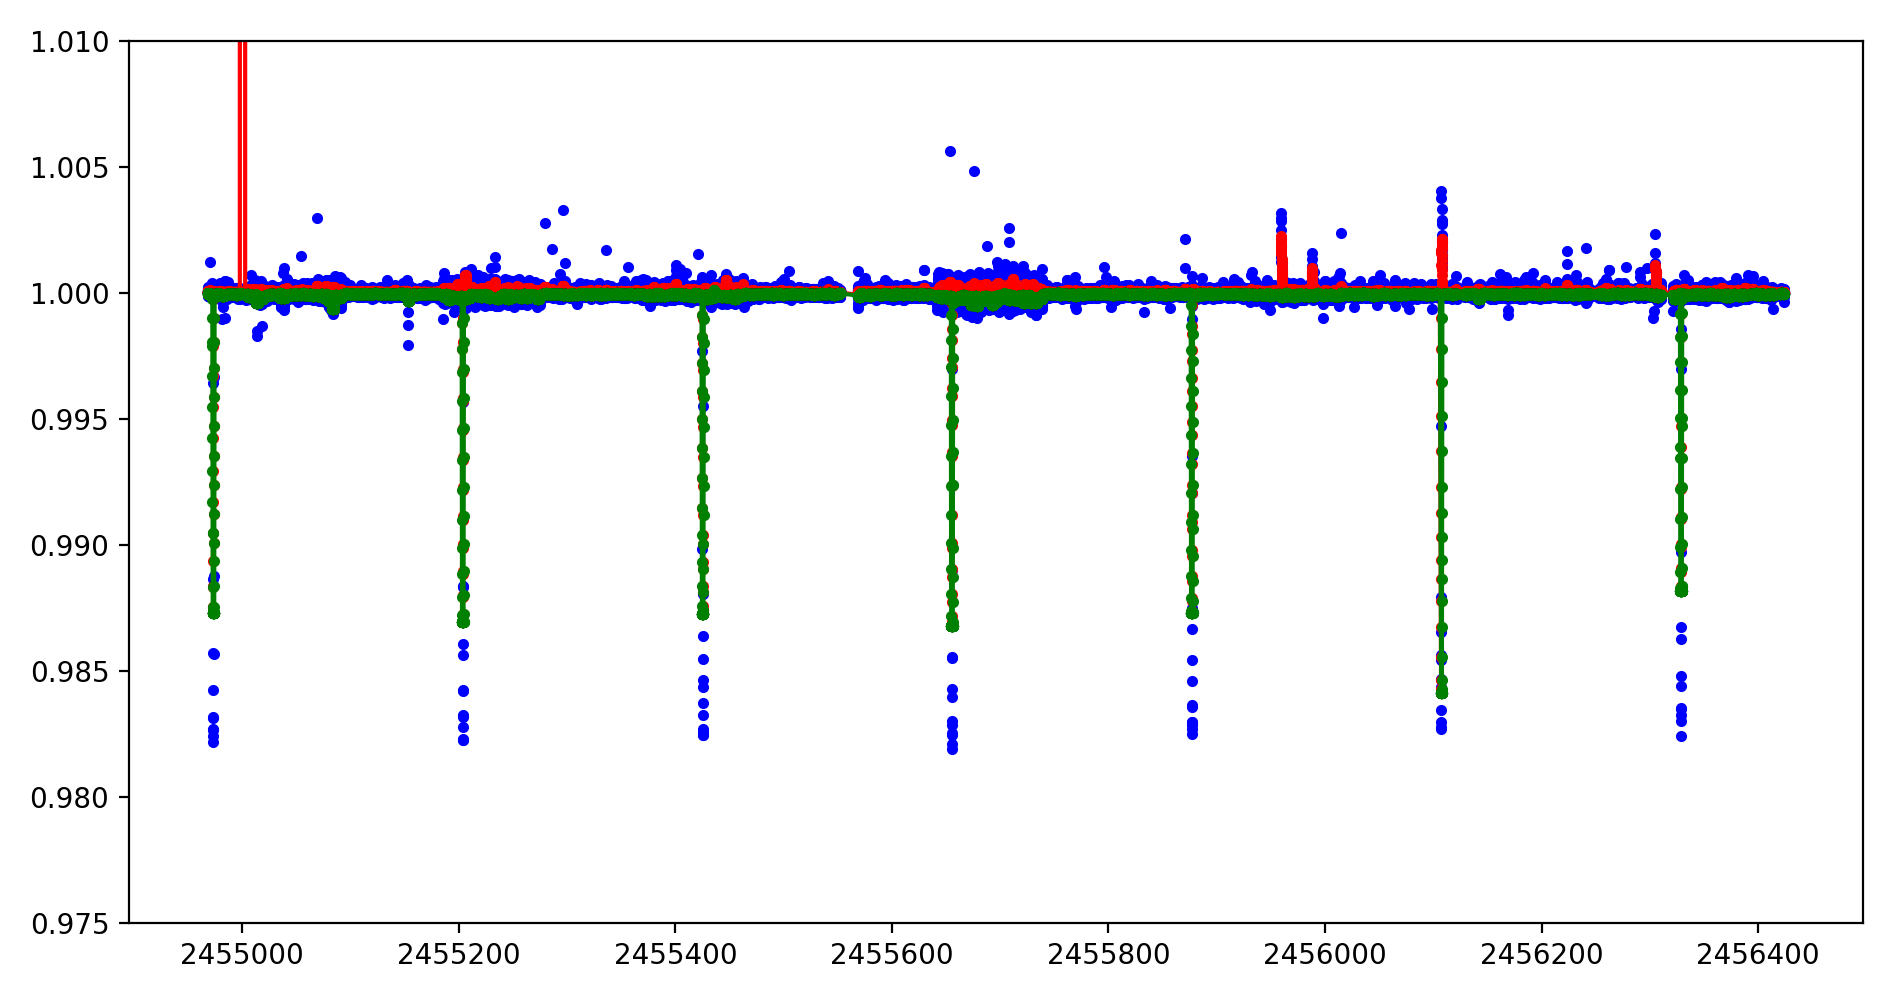

In [5]:
# compare the statistic to the light curve
fig, ax = plt.subplots(figsize=(9.5,5))
ax.plot(time,flux,'b.')
ax.plot(time,stat[0.3]+1,'r.-')
ax.plot(time,blur_stat[0.3]+1,'g.-')
ax.set_ylim(0.975,1.01)
fig.tight_layout()

In [6]:
# load nbody data, for transits of primary
data_dir = '/storage/astro2/phsxfz/cb/'
data_dir = '../nbody_data/'
with open(data_dir+'k16-0-nbody.pkl', 'rb') as handle:
    tts_all = pickle.load(handle)
    tds_all = pickle.load(handle)

# for transits of secondary
with open(data_dir+'k16-1-nbody.pkl', 'rb') as handle:
    tts_all_2 = pickle.load(handle)
    tds_all_2 = pickle.load(handle)

In [7]:
# extract the periods and anomalies used in the simulation
periods_keys = list(tts_all.keys())
periods = np.array(periods_keys, dtype=float)
anomalies_keys = list(tts_all[list(tts_all.keys())[0]].keys())
anomalies = np.array(anomalies_keys, dtype=float)

In [8]:
# make the periodogram
periodogram = funcs.make_periodogram(tts_all, tds_all, time, windows, blur_stat)

<IPython.core.display.Javascript object>


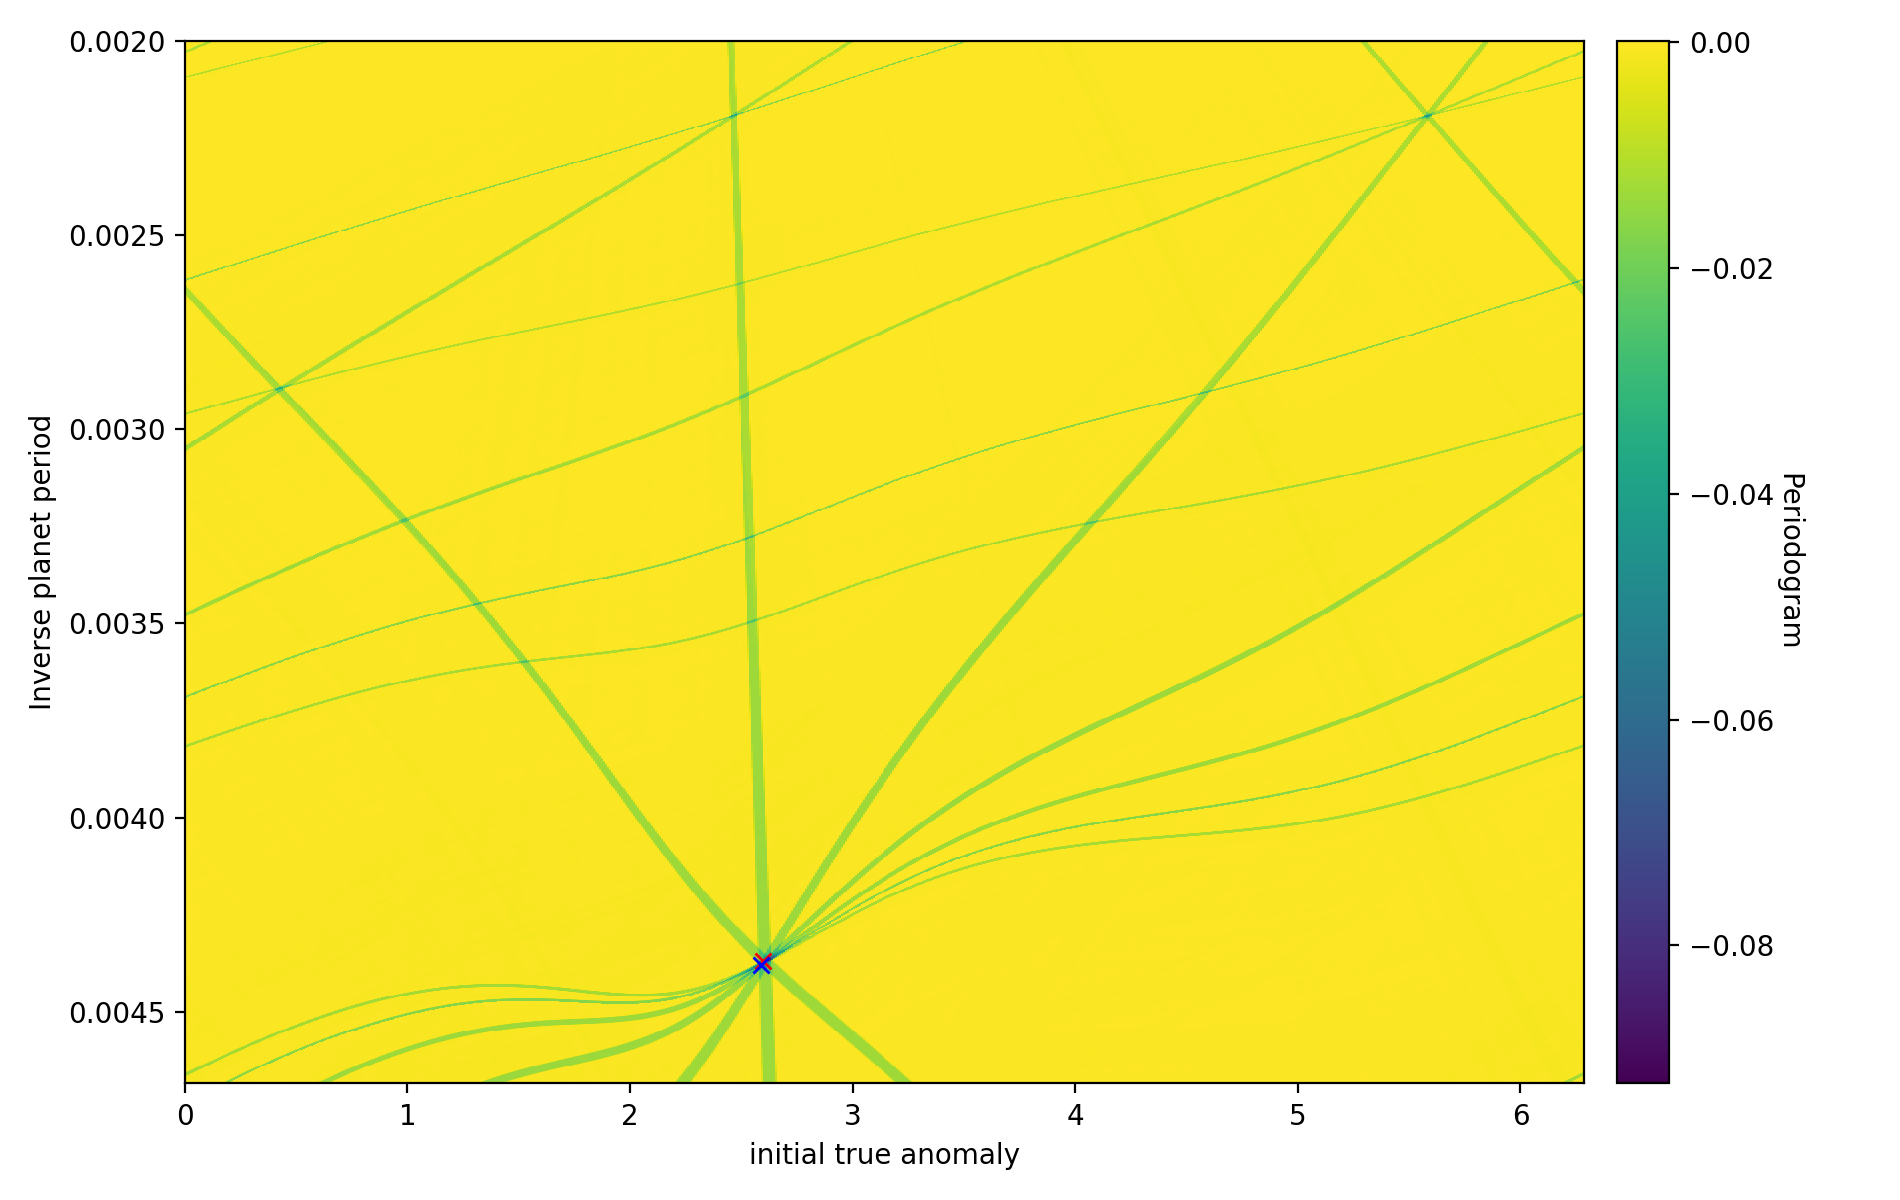

periodogram min:-0.09222332568574437
periodogram s/n:32.96740485598488
transit times:[2454974.04573697 2455204.12204902 2455425.50707926 2455655.58939284
 2455876.96206698 2456107.03926161 2456328.40328647]


In [9]:
# show the periodogram in the 2d space
fig, ax = plt.subplots(figsize=(9.5,6))
palette = plt.cm.viridis
c = ax.imshow(periodogram,origin='lower',
              extent=[np.min(anomalies),np.max(anomalies),1./np.min(periods),1./np.max(periods)],
              aspect='auto',cmap=palette,
              vmax=None)
cbar = fig.colorbar(c, pad=0.02)
cbar.set_label('Periodogram', rotation=270, labelpad=10)
ax.set_ylabel('Inverse planet period')
ax.set_xlabel('initial true anomaly')

# the known planet
ax.plot(f_p0,1./p_p0,'rx')

print('periodogram min:{}'.format(np.min(periodogram)))
print('periodogram s/n:{}'.format(-(np.min(periodogram)-np.mean(periodogram))/np.std(periodogram)))

# the found 'planet'
minidx = np.unravel_index(np.argmin(periodogram),(len(periods),len(anomalies)))
ax.plot(anomalies[minidx[1]],1./periods[minidx[0]],'bx')
pp = periods_keys[minidx[0]]
fp = anomalies_keys[minidx[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
print('transit times:{}'.format(tts))

fig.tight_layout()